Enter cryptocurrency name (e.g., bitcoin, ethereum) or type 'done' to finish: solana
Enter quantity of Solana: 1
Enter purchase price of Solana: 21
Enter cryptocurrency name (e.g., bitcoin, ethereum) or type 'done' to finish: bitcoin
Enter quantity of Bitcoin: 1
Enter purchase price of Bitcoin: 2134
Enter cryptocurrency name (e.g., bitcoin, ethereum) or type 'done' to finish: done

Total Portfolio Value: $96572.47
Solana: Profit = $209.47 (997.48%)
Bitcoin: Profit = $94208.00 (4414.62%)

Select a cryptocurrency from your portfolio to see the price prediction:
1. Solana
2. Bitcoin
Enter the number of the cryptocurrency to see the chart: 2

Showing price prediction for Bitcoin...

Predicted Bitcoin price for tomorrow: $100561.10


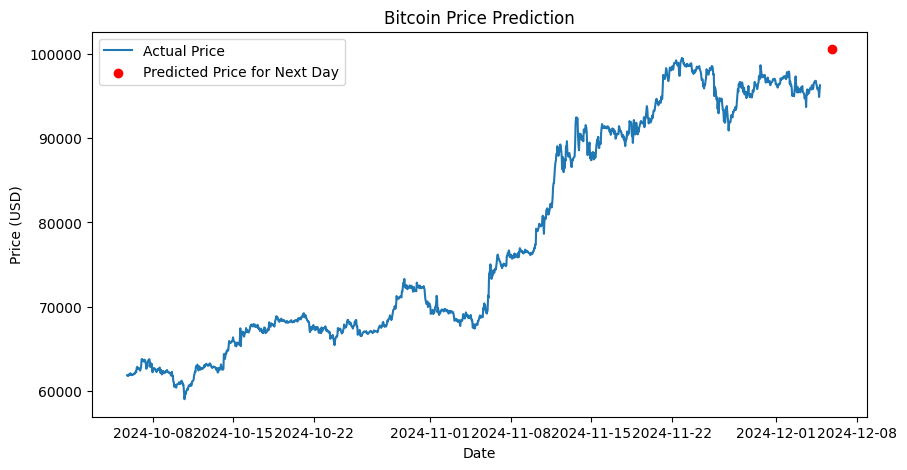

In [4]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from datetime import datetime

def get_historical_data(crypto_id):
    url = f"https://api.coingecko.com/api/v3/coins/{crypto_id}/market_chart?vs_currency=usd&days=60"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        if 'prices' in data and data['prices']:
            prices = pd.DataFrame(data['prices'], columns=['timestamp', 'price'])
            prices['date'] = pd.to_datetime(prices['timestamp'], unit='ms')
            return prices[['date', 'price']]
        else:
            print(f"Error: 'prices' key not found or empty for {crypto_id}.")
            return pd.DataFrame()
    else:
        print(f"Error: API request failed for {crypto_id}.")
        return pd.DataFrame()

def get_real_time_price(crypto_id):
    url = f'https://api.coingecko.com/api/v3/simple/price?ids={crypto_id}&vs_currencies=usd'
    response = requests.get(url)
    data = response.json()
    return data[crypto_id]['usd']

def calculate_portfolio_value(portfolio):
    total_value = 0
    profit_loss = {}

    for crypto, data in portfolio.items():
        current_price = get_real_time_price(crypto.lower())
        value = data['quantity'] * current_price
        pnl = (current_price - data['purchase_price']) * data['quantity']

        pnl_type = "Profit" if pnl > 0 else "Loss"
        percentage_pnl = (pnl / (data['purchase_price'] * data['quantity'])) * 100

        profit_loss[crypto] = {"type": pnl_type, "amount": pnl, "percentage": percentage_pnl}
        total_value += value

    return total_value, profit_loss

def prepare_data_for_prediction(prices):
    prices['date'] = prices['date'].map(pd.Timestamp.to_julian_date)
    X = prices['date'].values.reshape(-1, 1)
    y = prices['price'].values
    return X, y

def train_price_prediction_model(crypto_id):
    prices = get_historical_data(crypto_id)
    X, y = prepare_data_for_prediction(prices)
    model = LinearRegression()
    model.fit(X, y)
    return model

def predict_next_day_price(model, future_date):
    future_date_julian = np.array([future_date.to_julian_date()]).reshape(-1, 1)
    predicted_price = model.predict(future_date_julian)
    return predicted_price[0]

def plot_portfolio_and_prediction(prices, predicted_price, future_date, crypto_id):
    plt.figure(figsize=(10, 5))
    plt.plot(prices['date'], prices['price'], label='Actual Price')
    plt.scatter(future_date, predicted_price, color='red', label='Predicted Price for Next Day')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.title(f'{crypto_id.capitalize()} Price Prediction')
    plt.legend()
    plt.show()

def get_user_portfolio():
    portfolio = {}
    while True:
        crypto = input("Enter cryptocurrency name (e.g., bitcoin, ethereum) or type 'done' to finish: ").lower()
        if crypto == 'done':
            break
        try:
            quantity = float(input(f"Enter quantity of {crypto.capitalize()}: "))
            purchase_price = float(input(f"Enter purchase price of {crypto.capitalize()}: "))
            portfolio[crypto] = {'quantity': quantity, 'purchase_price': purchase_price}
        except ValueError:
            print("Invalid input! Please enter numeric values for quantity and purchase price.")
    return portfolio

def run_project():
    portfolio = get_user_portfolio()
    if not portfolio:
        print("No portfolio added. Exiting...")
        return

    total_value, profit_loss = calculate_portfolio_value(portfolio)
    print(f"\nTotal Portfolio Value: ${total_value:.2f}")
    for crypto, pnl in profit_loss.items():
        print(f"{crypto.capitalize()}: {pnl['type']} = ${pnl['amount']:.2f} ({pnl['percentage']:.2f}%)")

    if len(portfolio) == 1:
        selected_crypto = list(portfolio.keys())[0]
        print(f"\nShowing price prediction for {selected_crypto.capitalize()}...")
        model = train_price_prediction_model(selected_crypto)

        future_date = pd.to_datetime("today") + pd.DateOffset(days=1)
        predicted_price = predict_next_day_price(model, future_date)
        print(f"\nPredicted {selected_crypto.capitalize()} price for tomorrow: ${predicted_price:.2f}")

        prices = get_historical_data(selected_crypto)
        plot_portfolio_and_prediction(prices, predicted_price, future_date, selected_crypto)

        return

    print("\nSelect a cryptocurrency from your portfolio to see the price prediction:")
    for idx, crypto in enumerate(portfolio.keys(), start=1):
        print(f"{idx}. {crypto.capitalize()}")

    choice = input("Enter the number of the cryptocurrency to see the chart: ").lower()

    try:
        choice = int(choice) - 1
        selected_crypto = list(portfolio.keys())[choice]

        print(f"\nShowing price prediction for {selected_crypto.capitalize()}...")
        model = train_price_prediction_model(selected_crypto)

        future_date = pd.to_datetime("today") + pd.DateOffset(days=1)
        predicted_price = predict_next_day_price(model, future_date)
        print(f"\nPredicted {selected_crypto.capitalize()} price for tomorrow: ${predicted_price:.2f}")

        prices = get_historical_data(selected_crypto)
        plot_portfolio_and_prediction(prices, predicted_price, future_date, selected_crypto)

    except (ValueError, IndexError):
        print("Invalid selection. Exiting program.")

if __name__ == "__main__":
    run_project()


In [ ]:
2